In [1]:
%matplotlib inline
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping

/home/nao/.pyenv/versions/3.6.9/envs/py36_tf2/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
#np.random.seed(123)
#tf.random.set_seed(123)

file_paths = glob.glob("./data/*")
print(file_paths)

['./data/20200323b_not_seating.csv', './data/20200323a_seating.csv', './data/20200322a_not_seating.csv', './data/20200324d_not_seating.csv', './data/20200319_seating.csv', './data/20200325e_not_seating.csv', './data/20200326b_not_seating.csv', './data/20200319_not_seating.csv', './data/20200325c_seating.csv', './data/20200326a_seating.csv', './data/20200324f_seating.csv', './data/20200323c_not_seating.csv', './data/20200324a_seating.csv', './data/20200324c_not_seating.csv', './data/20200325a_seating.csv', './data/20200324b_seating.csv', './data/20200325b_seating.csv']


In [3]:
category =np.empty((0,1), float)
rssi =np.empty((0,100,1), float)

for file in file_paths:
    d = np.loadtxt(file, delimiter=',')
    category_tmp, rssi_tmp = np.hsplit(d, [1])
    for rssi_line in rssi_tmp:
        rssi_line = [rssi_line.reshape(100, -1)]
        rssi = np.concatenate([rssi, rssi_line], axis=0)
    category = np.concatenate([category, category_tmp], axis=0)

rssi = rssi * (-1) / 128
print("rssi array shape : ", rssi.shape)
#print(rssi)
#category = tf.keras.utils.to_categorical(category, 2)
print("category array shape : ", category.shape)
#print(category)

x_train, x_val, t_train, t_val = train_test_split(rssi, category, test_size=0.2)
print("x training array shape : ", x_train.shape)
#print(x_train)
print("t training array shape : ", t_train.shape)
#print(t_train)
print("rssi test array shape : ", x_val.shape)
print("category test array shape : ", t_val.shape)

rssi array shape :  (7297, 100, 1)
category array shape :  (7297, 1)
x training array shape :  (5837, 100, 1)
t training array shape :  (5837, 1)
rssi test array shape :  (1460, 100, 1)
category test array shape :  (1460, 1)


In [4]:
class BiRNN(Model):
    def __init__(self, hidden_dim):
        super().__init__()
        self.l1 = Bidirectional(LSTM(hidden_dim, activation='tanh',
                                     recurrent_activation='sigmoid',
                                     kernel_initializer='glorot_normal',
                                     recurrent_initializer='orthogonal'),
                                merge_mode='concat')
        self.l2 = Dense(2, kernel_initializer='glorot_normal',
                        activation='softmax')

    def call(self, x):
        h = self.l1(x)
        y = self.l2(h)
        return y

model = BiRNN(25)

criterion = losses.SparseCategoricalCrossentropy()
optimizer = optimizers.Adam(learning_rate=0.001,
                                beta_1=0.9, beta_2=0.999, amsgrad=True)
train_loss = metrics.Mean()
train_acc = metrics.SparseCategoricalAccuracy()
val_loss = metrics.Mean()
val_acc = metrics.SparseCategoricalAccuracy()

In [5]:
def compute_loss(t, y):
    return criterion(t, y)

def train_step(x, t):
    with tf.GradientTape() as tape:
        preds = model(x)
        loss = compute_loss(t, preds)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(loss)
    train_acc(t, preds)

    return loss

def val_step(x, t):
    preds = model(x)
    loss = compute_loss(t, preds)
    val_loss(loss)
    val_acc(t, preds)

epochs = 256
batch_size = 256
n_batches_train = x_train.shape[0] // batch_size
n_batches_val = x_val.shape[0] // batch_size
hist = {'loss': [], 'accuracy': [],
        'val_loss': [], 'val_accuracy': []}

In [6]:
for epoch in range(epochs):
    x_, t_ = shuffle(x_train, t_train)
    
    for batch in range(n_batches_train):
        start = batch * batch_size
        end = start + batch_size
        train_step(x_[start:end], t_[start:end])
    #print('1')    

    for batch in range(n_batches_val):
        start = batch * batch_size
        end = start + batch_size
        val_step(x_val[start:end], t_val[start:end])
    #print('2')

    hist['loss'].append(train_loss.result())
    hist['accuracy'].append(train_acc.result())
    hist['val_loss'].append(val_loss.result())
    hist['val_accuracy'].append(val_acc.result())

    print('epoch: {}, loss: {:.3}, acc: {:.3f}'
          ', val_loss: {:.3}, val_acc: {:.3f}'.format(
              epoch+1,
              train_loss.result(),
              train_acc.result(),
              val_loss.result(),
              val_acc.result()
          ))



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch: 1, loss: 0.669, acc: 0.621, val_loss: 0.667, val_acc: 0.621
epoch: 2, loss: 0.668, acc: 0.621, val_loss: 0.666, val_acc: 0.621
epoch: 3, loss: 0.667, acc: 0.621, val_loss: 0.666, val_acc: 0.621
epoch: 4, loss: 0.667, acc: 0.621, val_loss: 0.666, val_acc: 0.621
epoch: 5, loss: 0.667, acc: 0.620, val_loss: 0.666, val_acc: 0.621
epoch: 6, loss: 0.666, acc: 0.620, val_loss: 0.666, val_acc: 0.621
epoch: 7, loss: 0.666, acc: 0.620, val_loss: 0.665, val_acc: 0.621
epoch: 8, loss: 0.666, acc: 0.620, val_

epoch: 112, loss: 0.573, acc: 0.723, val_loss: 0.56, val_acc: 0.732
epoch: 113, loss: 0.573, acc: 0.723, val_loss: 0.559, val_acc: 0.732
epoch: 114, loss: 0.573, acc: 0.723, val_loss: 0.559, val_acc: 0.732
epoch: 115, loss: 0.573, acc: 0.724, val_loss: 0.559, val_acc: 0.733
epoch: 116, loss: 0.573, acc: 0.724, val_loss: 0.559, val_acc: 0.733
epoch: 117, loss: 0.573, acc: 0.724, val_loss: 0.559, val_acc: 0.733
epoch: 118, loss: 0.573, acc: 0.724, val_loss: 0.559, val_acc: 0.733
epoch: 119, loss: 0.572, acc: 0.724, val_loss: 0.559, val_acc: 0.733
epoch: 120, loss: 0.572, acc: 0.724, val_loss: 0.559, val_acc: 0.733
epoch: 121, loss: 0.572, acc: 0.724, val_loss: 0.559, val_acc: 0.733
epoch: 122, loss: 0.572, acc: 0.724, val_loss: 0.558, val_acc: 0.733
epoch: 123, loss: 0.572, acc: 0.724, val_loss: 0.558, val_acc: 0.733
epoch: 124, loss: 0.572, acc: 0.725, val_loss: 0.558, val_acc: 0.734
epoch: 125, loss: 0.572, acc: 0.725, val_loss: 0.558, val_acc: 0.734
epoch: 126, loss: 0.572, acc: 0.725

epoch: 231, loss: 0.564, acc: 0.730, val_loss: 0.55, val_acc: 0.739
epoch: 232, loss: 0.564, acc: 0.731, val_loss: 0.55, val_acc: 0.739
epoch: 233, loss: 0.564, acc: 0.731, val_loss: 0.55, val_acc: 0.739
epoch: 234, loss: 0.564, acc: 0.731, val_loss: 0.55, val_acc: 0.739
epoch: 235, loss: 0.564, acc: 0.731, val_loss: 0.55, val_acc: 0.739
epoch: 236, loss: 0.564, acc: 0.731, val_loss: 0.55, val_acc: 0.739
epoch: 237, loss: 0.564, acc: 0.731, val_loss: 0.55, val_acc: 0.739
epoch: 238, loss: 0.564, acc: 0.731, val_loss: 0.55, val_acc: 0.739
epoch: 239, loss: 0.564, acc: 0.731, val_loss: 0.55, val_acc: 0.740
epoch: 240, loss: 0.564, acc: 0.731, val_loss: 0.55, val_acc: 0.740
epoch: 241, loss: 0.564, acc: 0.731, val_loss: 0.55, val_acc: 0.740
epoch: 242, loss: 0.564, acc: 0.731, val_loss: 0.55, val_acc: 0.740
epoch: 243, loss: 0.564, acc: 0.731, val_loss: 0.55, val_acc: 0.740
epoch: 244, loss: 0.563, acc: 0.731, val_loss: 0.55, val_acc: 0.740
epoch: 245, loss: 0.563, acc: 0.731, val_loss: 0

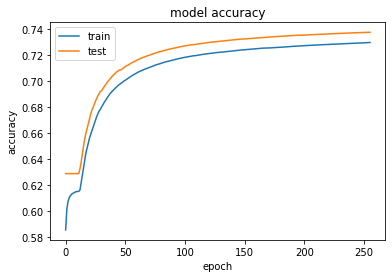

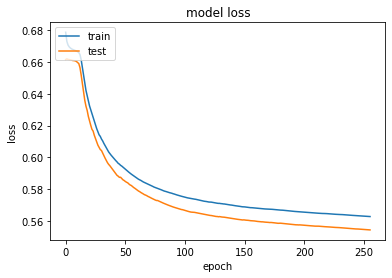

test_loss: 0.547, test_acc: 0.742


In [8]:
#正答率
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# テストデータの評価
test_loss = metrics.Mean()
test_acc = metrics.SparseCategoricalAccuracy()

def test_step(x, t):
    preds = model(x)
    loss = compute_loss(t, preds)
    test_loss(loss)
    test_acc(t, preds)

    return loss

test_step(x_val, t_val)

print('test_loss: {:.3f}, test_acc: {:.3f}'.format(
    test_loss.result(),
    test_acc.result()
))

In [66]:
rs =np.empty((0,5,1), float)
print(rs.shape)

r = np.array([[0,1,2,3,4],[5,6,7,8,9]])
print(r.shape)

for i in r:
    print(i.shape)
    print(i)
    i = np.array([i.reshape(5,-1)])
    print(i)
    rs = np.concatenate([rs, i], axis=0)
print(rs)

(0, 5, 1)
(2, 5)
(5,)
[0 1 2 3 4]
[[[0]
  [1]
  [2]
  [3]
  [4]]]
(5,)
[5 6 7 8 9]
[[[5]
  [6]
  [7]
  [8]
  [9]]]
[[[0.]
  [1.]
  [2.]
  [3.]
  [4.]]

 [[5.]
  [6.]
  [7.]
  [8.]
  [9.]]]
